In [1]:
!pip install torch

  Using cached torch-2.9.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvi

In [2]:
!pip install xdesign
!pip install scico

  Using cached xdesign-0.5.5-py3-none-any.whl
  Using cached scico-0.0.6-py3-none-any.whl.metadata (3.8 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.10.16-py3-none-any.whl.metadata (31 kB)
  Using cached jaxlib-0.4.35-cp311-cp311-manylinux2014_x86_64.whl.metadata (983 bytes)
  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
  Using cached orbax_checkpoint-0.11.26-py3-none-any.whl.metadata (2.4 kB)
  Using cached flax-0.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached PyAbel-0.9.1-py3-none-any.whl
  Using cached msgpack-1.1.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
  Using cached optax-0.2.6-py3-none-any.whl.metadata (7.6 kB)
  Using cached tensorstore-0.1.78-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (21 kB)
  Using cached ml_dtypes-0.5.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached opt_e

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import torch

from defocus import Microscope

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

import jax.numpy as jnp

(256, 256)

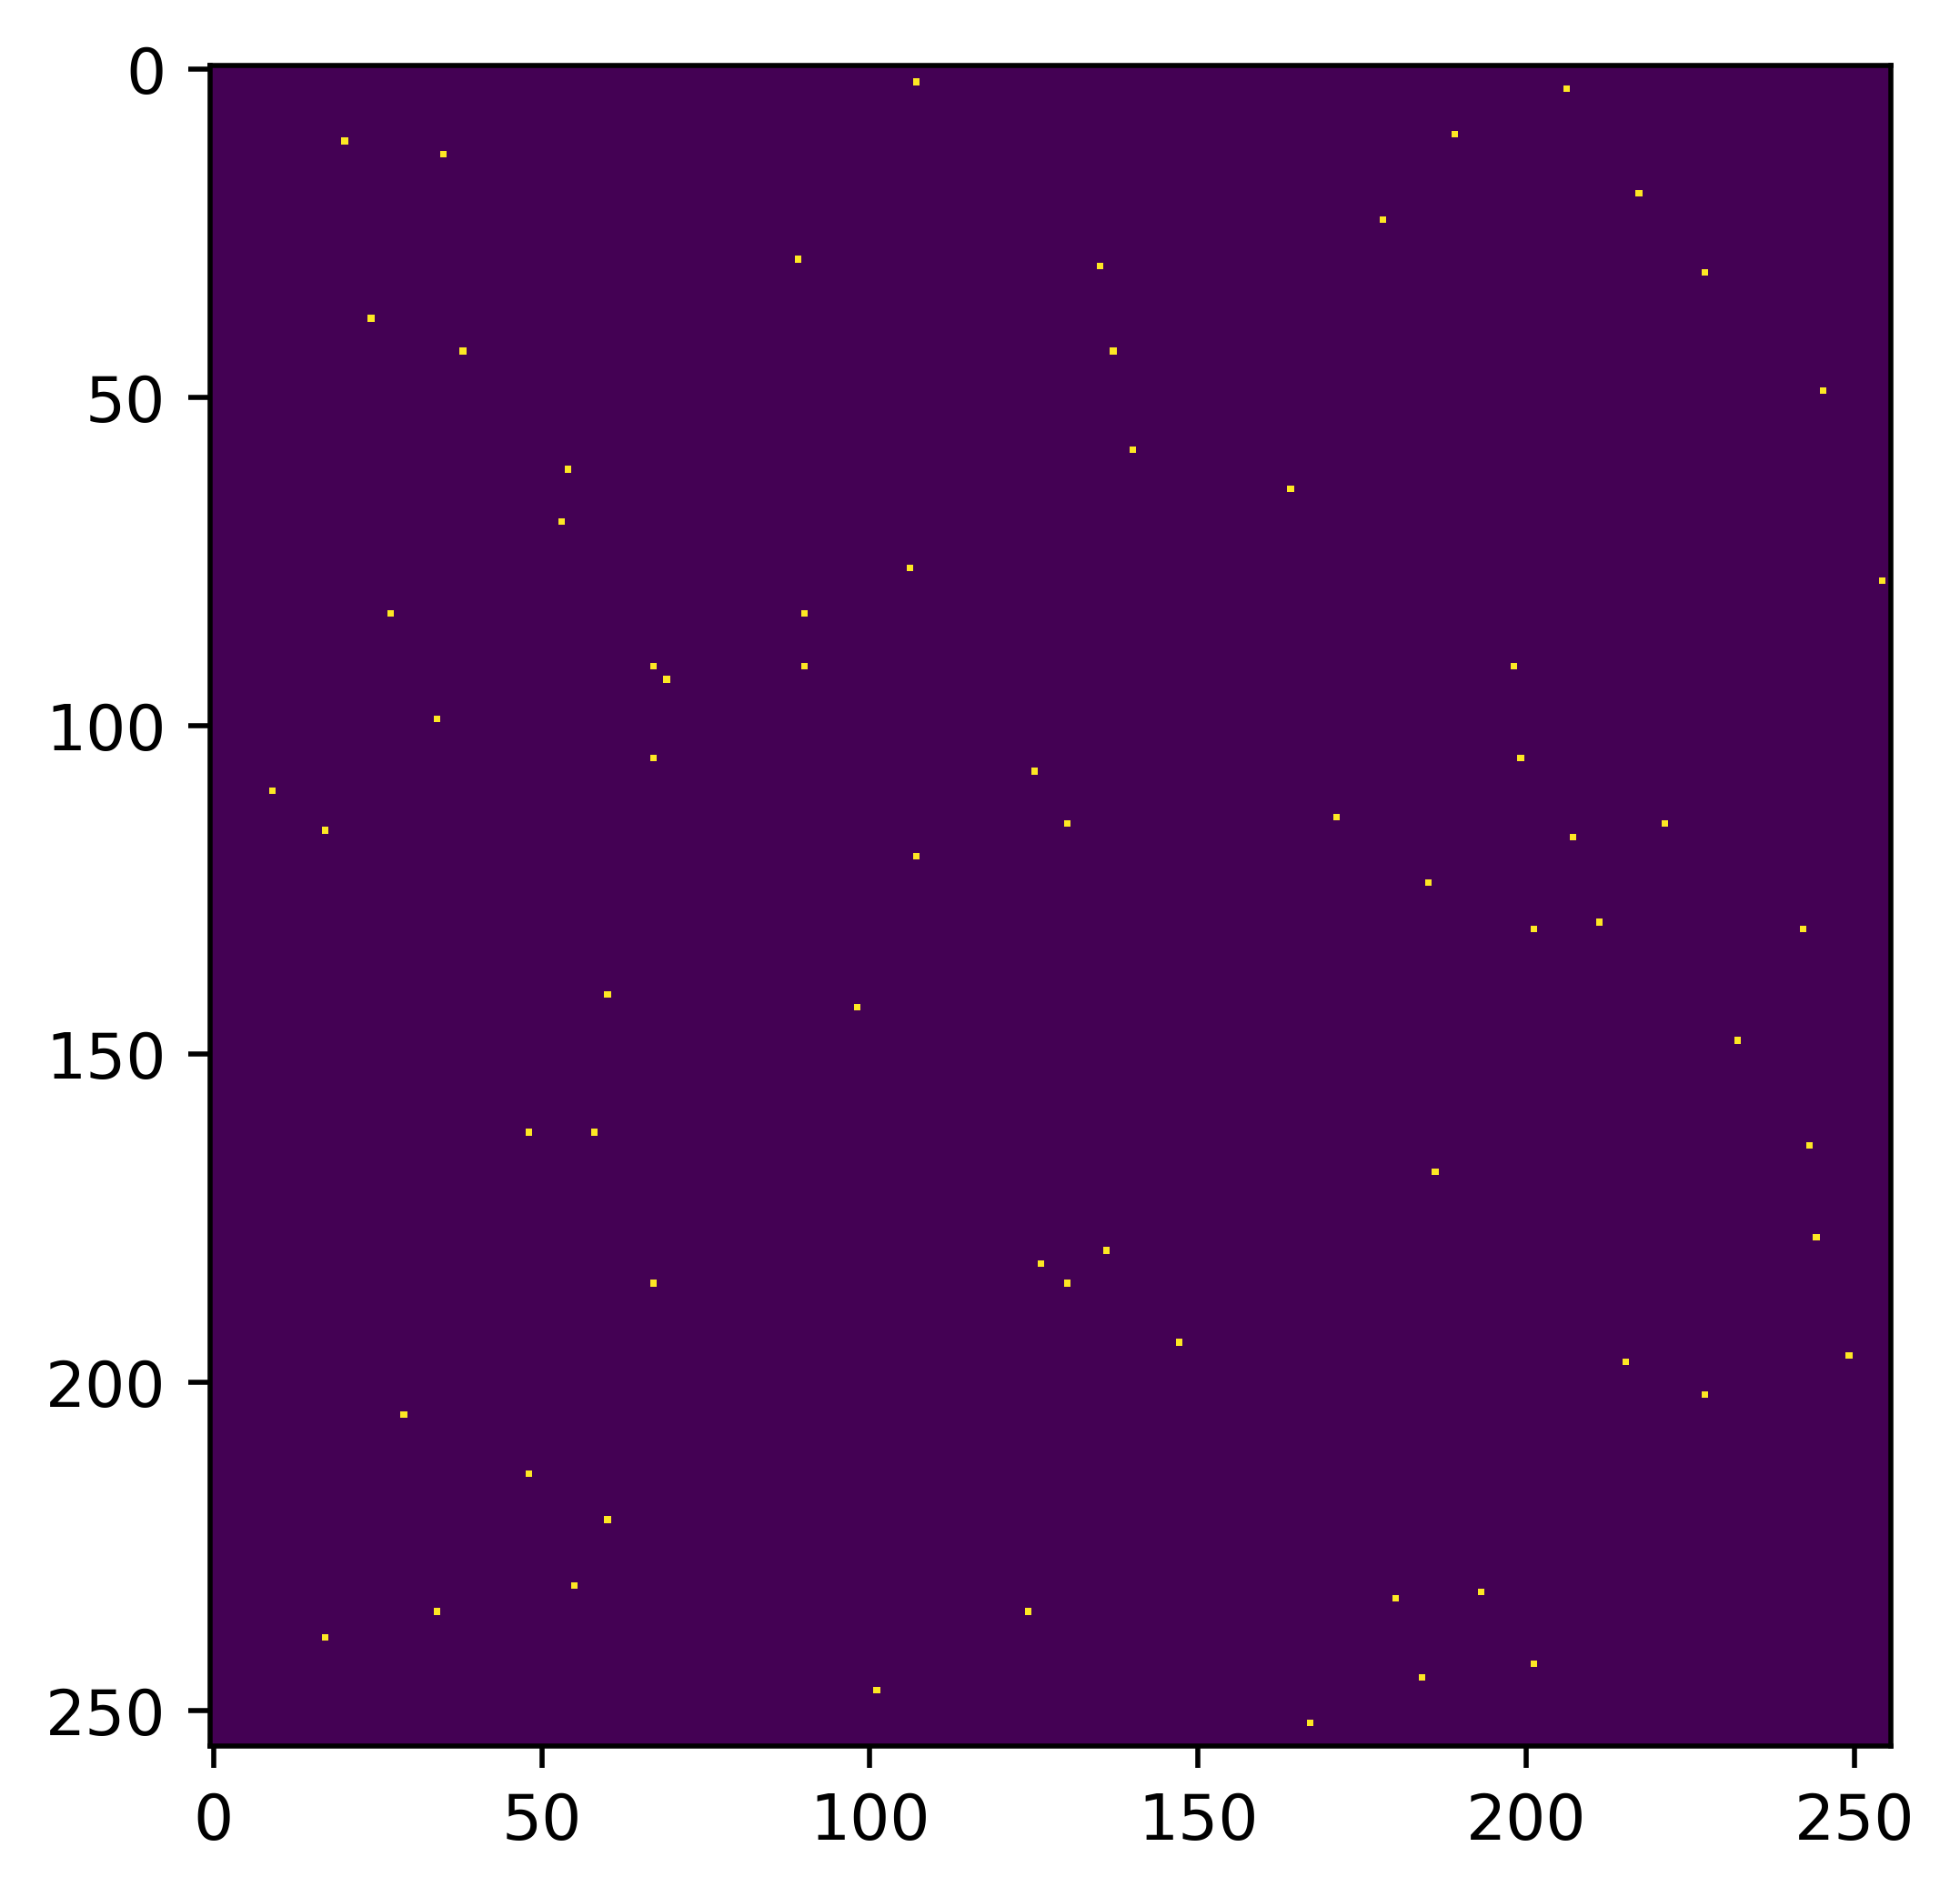

In [4]:
# Create Target Image

# phantom = SiemensStar(32)
# N = 256  # image size
# x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

# type(x_gt)
# x_gt.shape

np.random.seed(0)

image_size = 256
emitter_density = 0.001
pixel_size = 0.1e-6
image = np.random.choice([0,1], size=(image_size,image_size), p=[1-emitter_density, emitter_density])

x_gt = jnp.asarray(image)
plt.imshow(x_gt)

type(x_gt)
x_gt.shape

/srv/conda/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


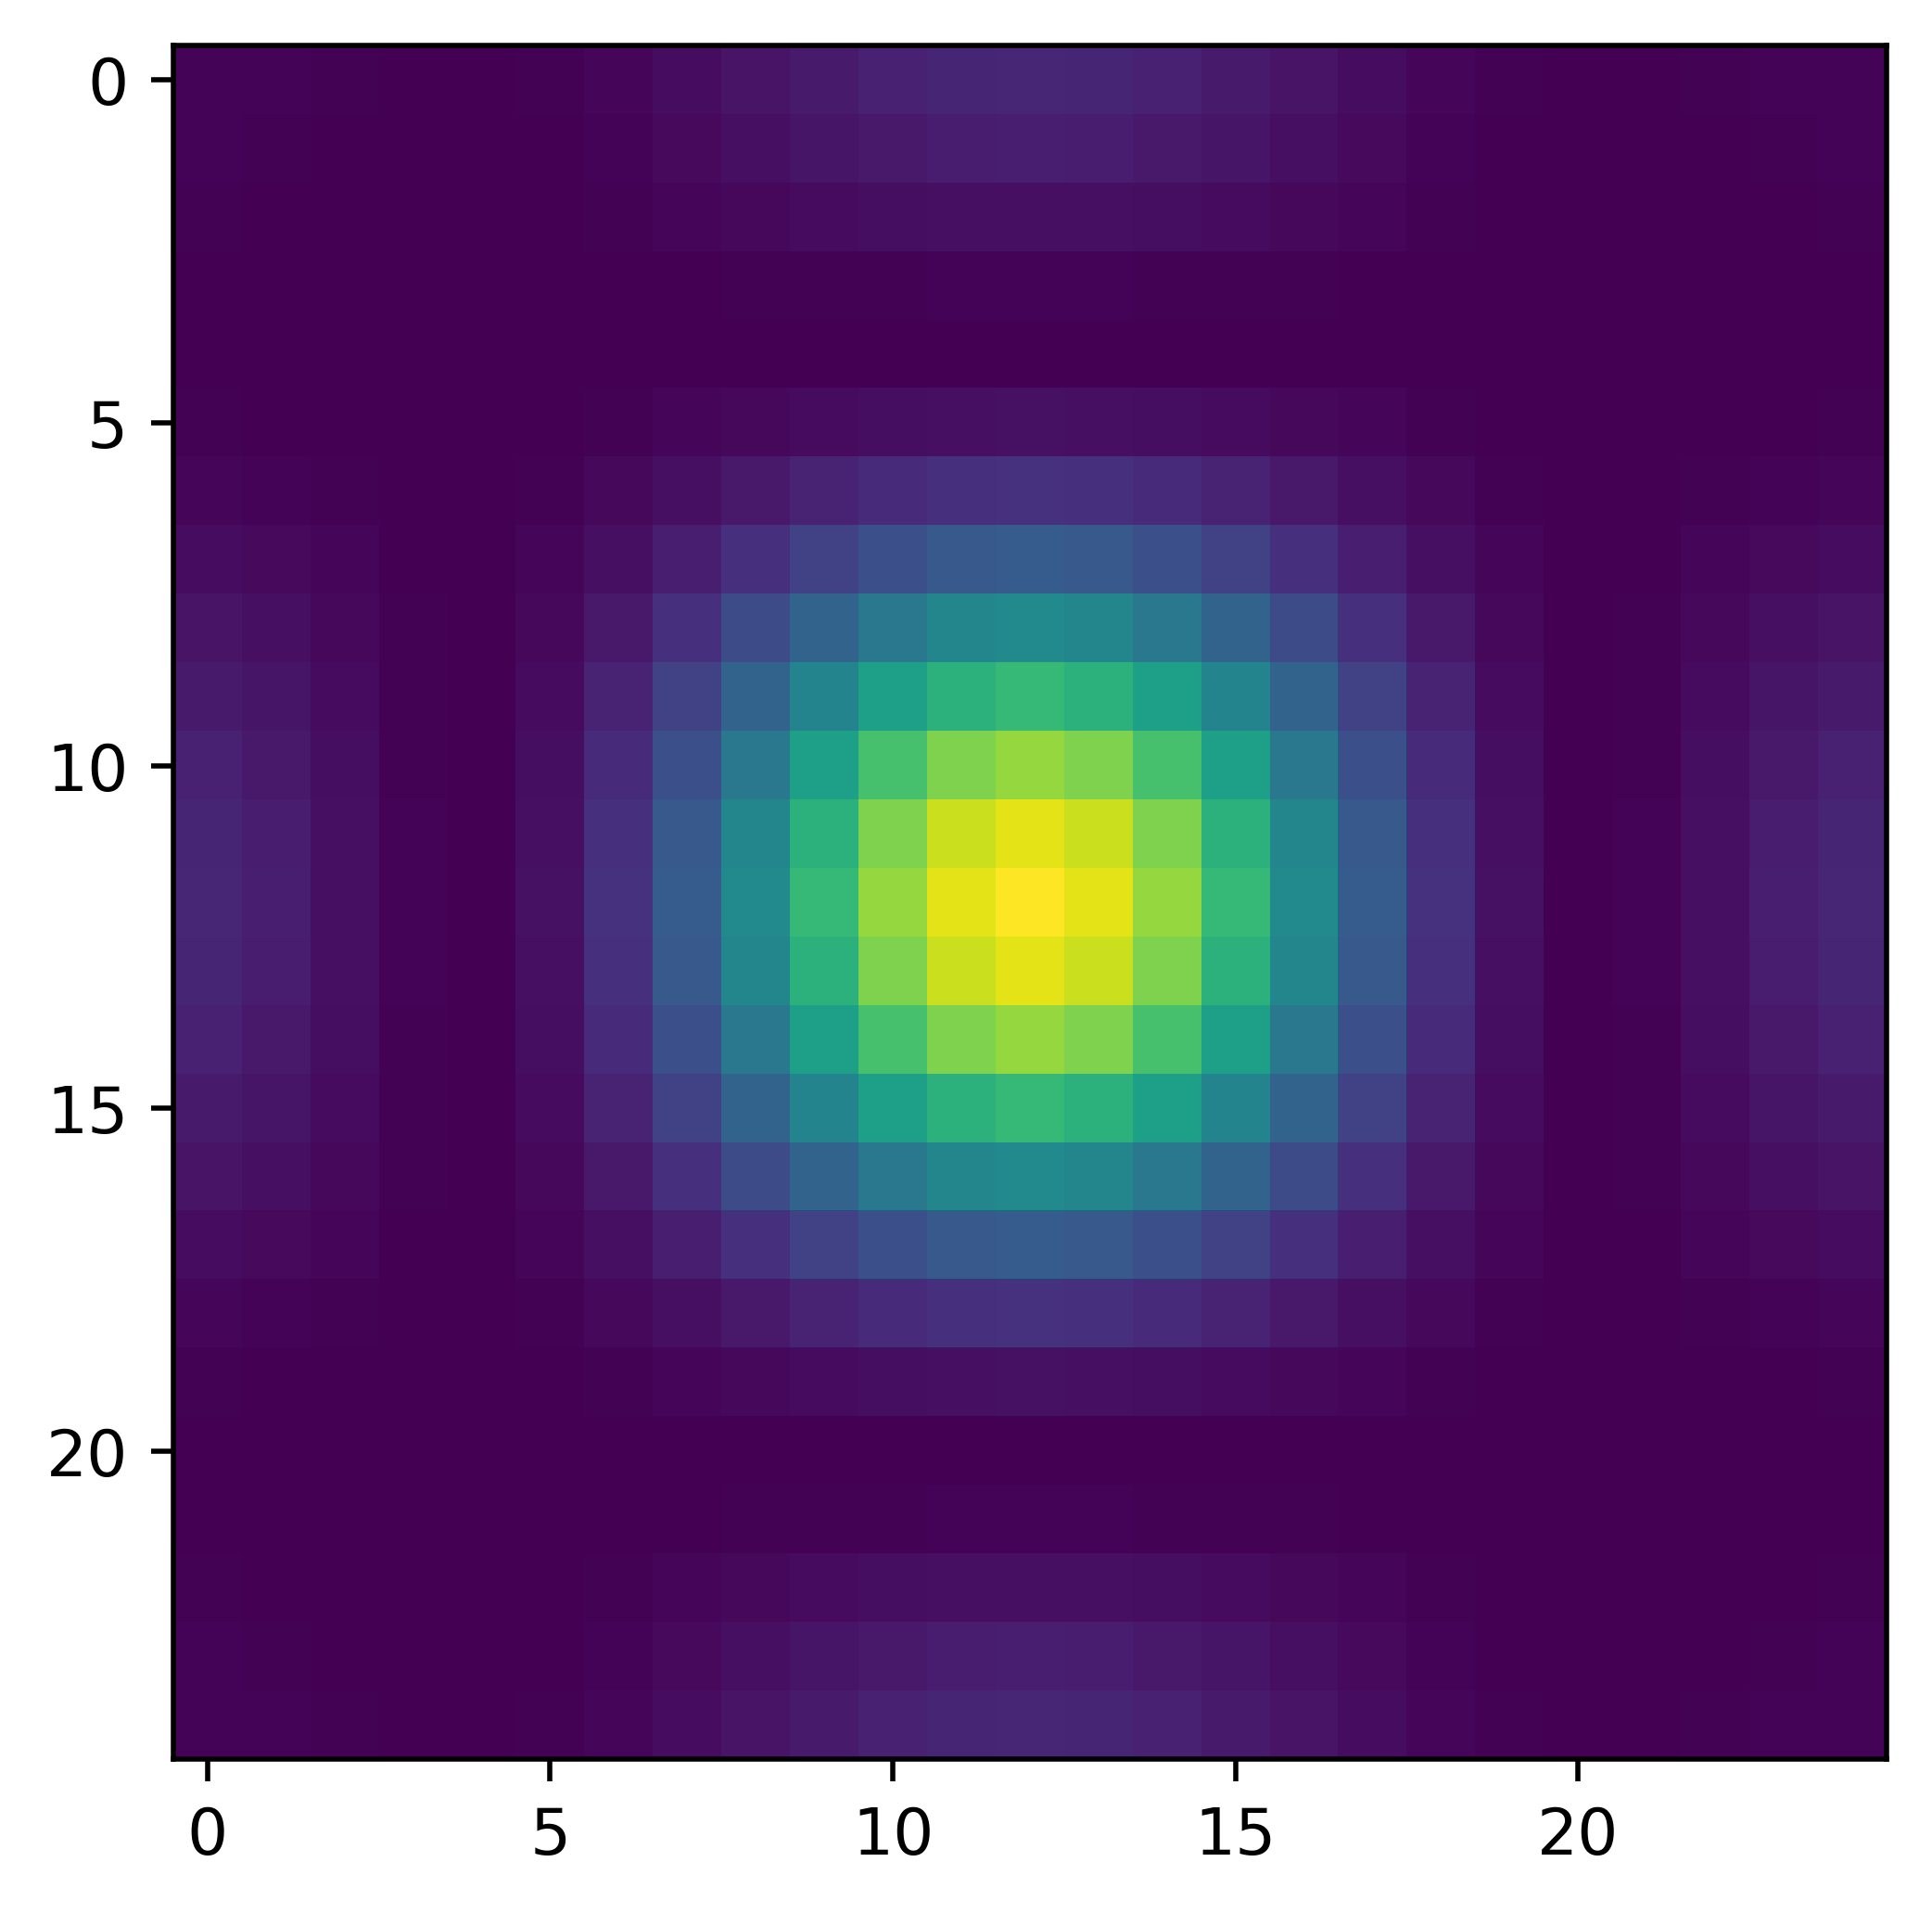

In [5]:
# Create Measurement from PSF

# n = 5  # convolution kernel size
# σ = 20.0 / 255  # noise level

# psf = snp.ones((n, n)) / (n * n)

# C = linop.Convolve(h=psf, input_shape=x_gt.shape)

# Cx = C(x_gt)  # blurred image
# noise, key = scico.random.randn(Cx.shape, seed=0)
# y = Cx + σ * noise

kernel_size = 25

device = torch.device('cpu')
scope = Microscope(dim=kernel_size, NA=0.5, mag=30, wavelength=500e-9, pixel_size=2e-6, device=device)
psf = scope.get_psf(defocus_length=0)

psf = psf.cpu().numpy()
psf = jnp.asarray(psf)
plt.imshow(psf)

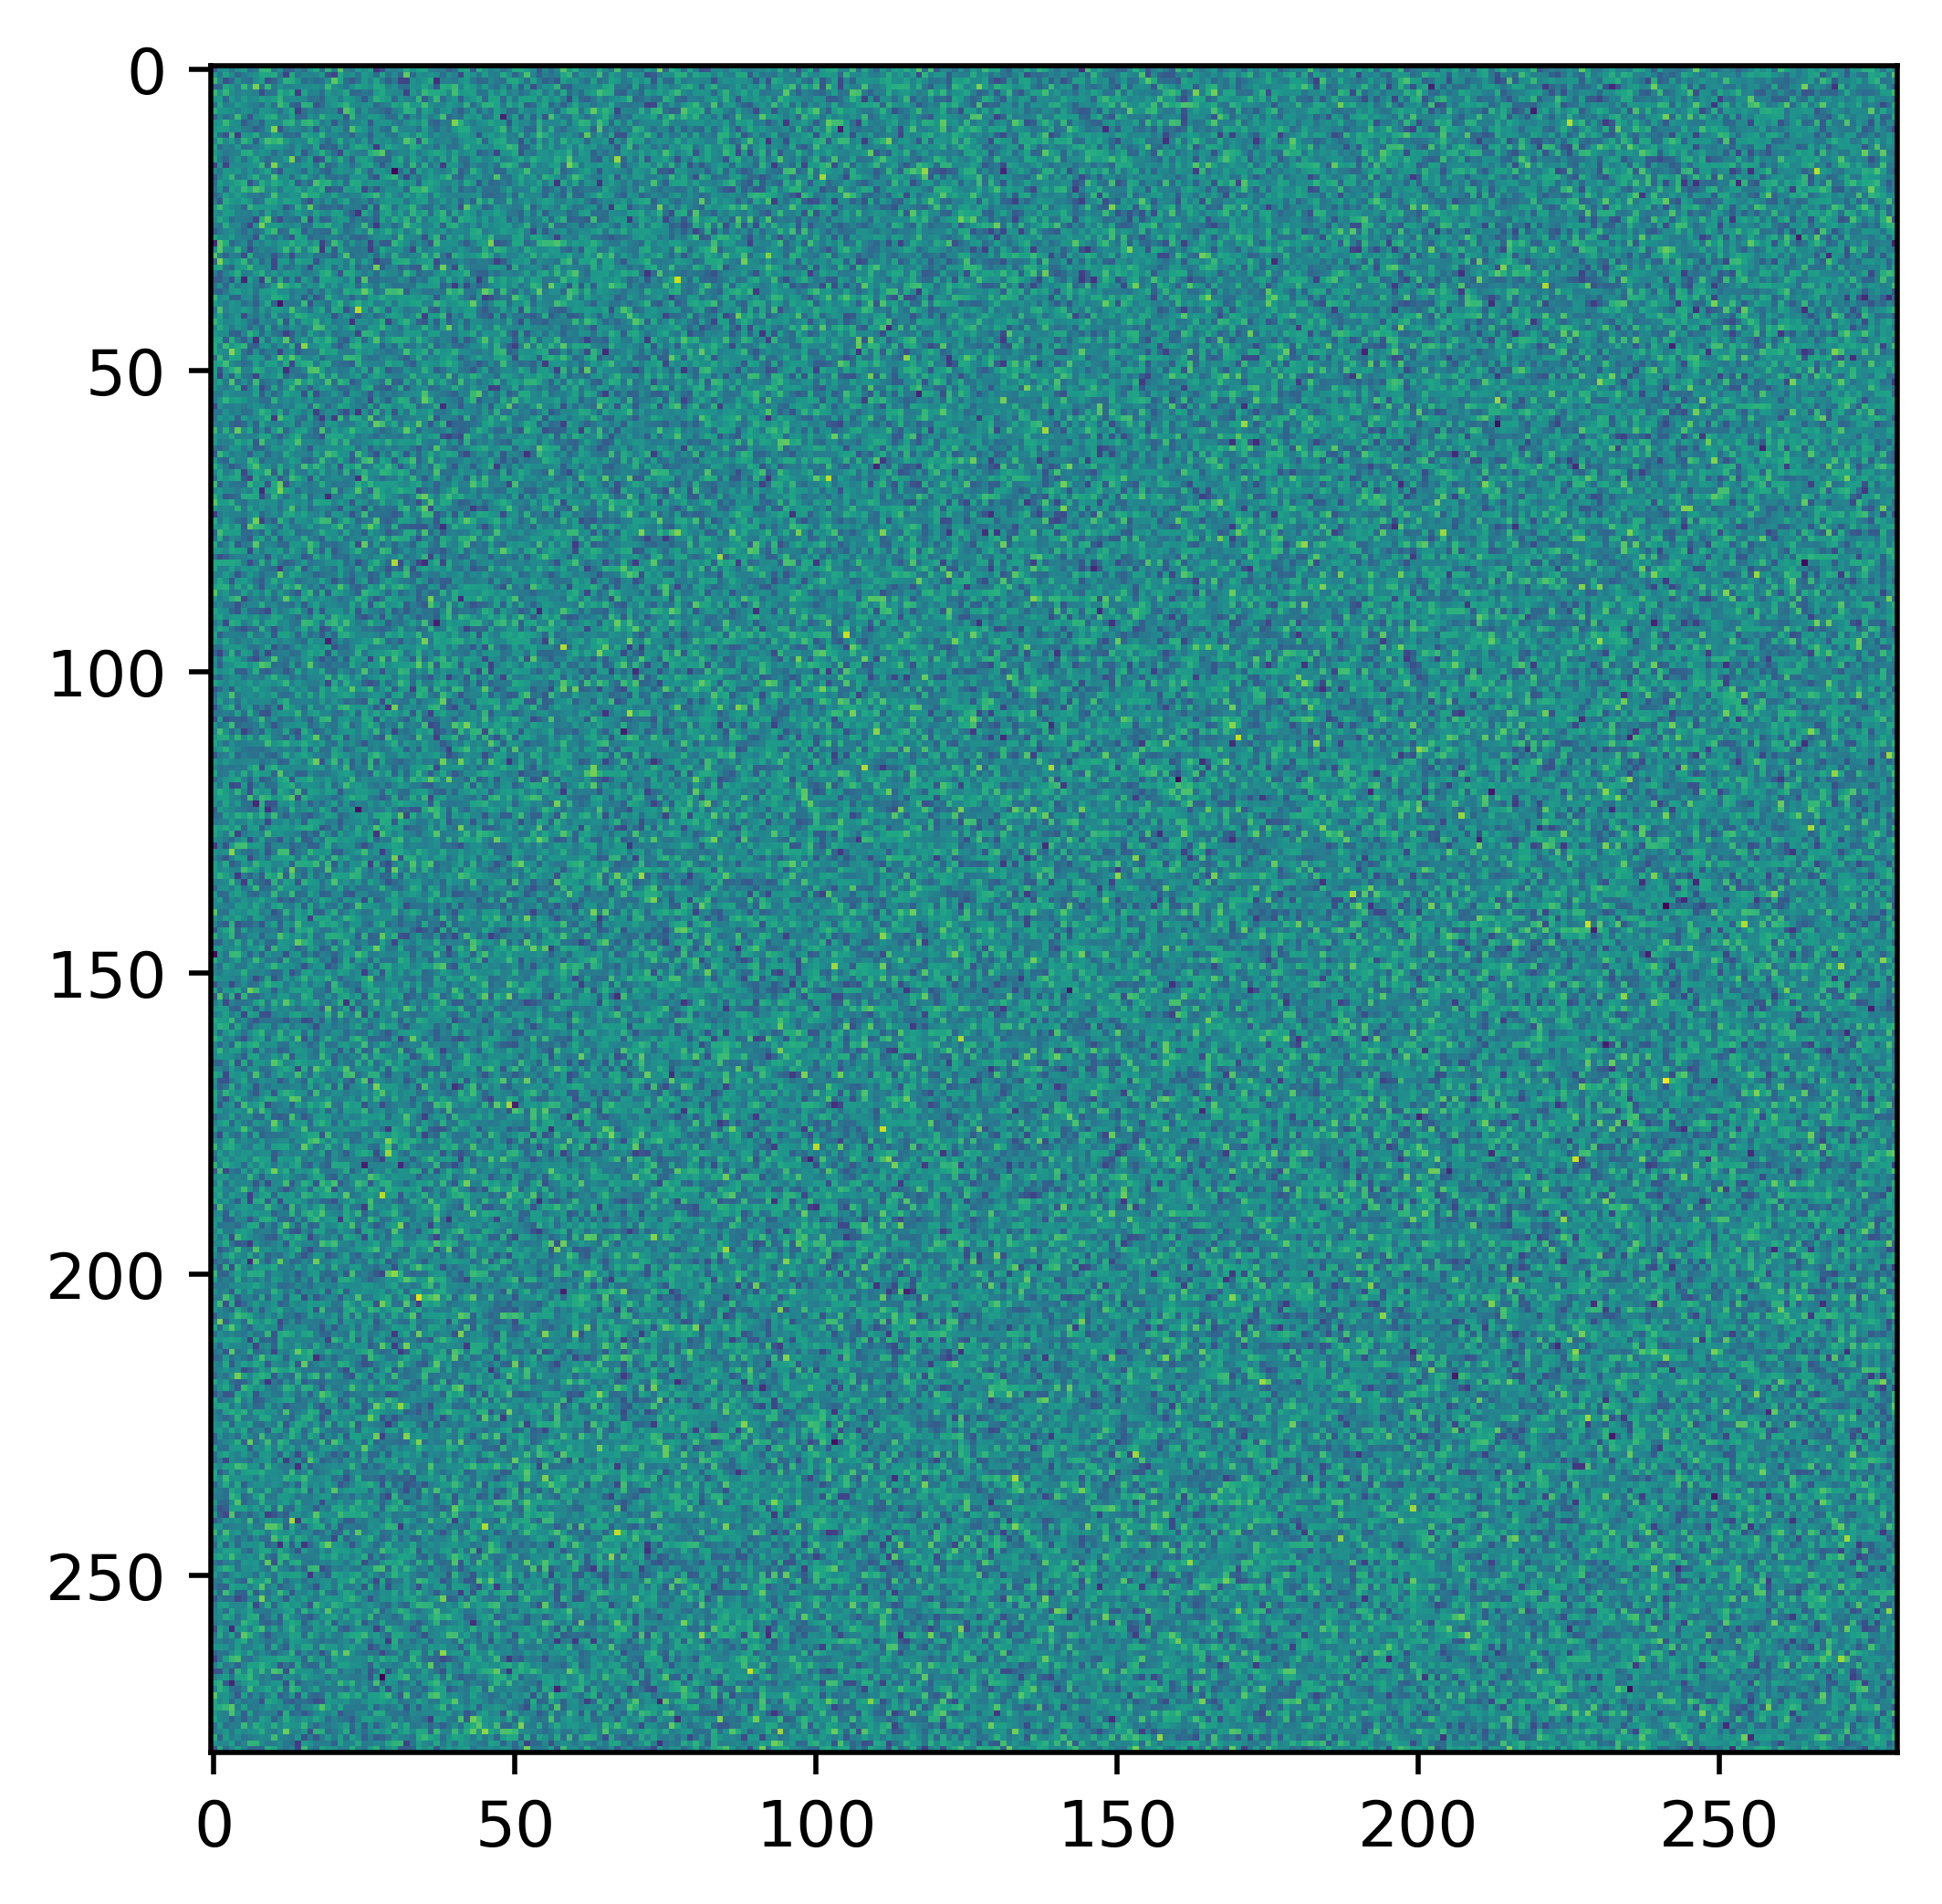

In [18]:
C = linop.Convolve(h=psf, input_shape=x_gt.shape)
Cx = C(x_gt)  # blurred image
# y = Cx[47:307:1, 47:307:1]
y = Cx

sig = 20.0 / 255

noise, key = scico.random.randn(Cx.shape, seed=0)
y = Cx + sig * noise

plt.imshow(y)

In [19]:
# cimage = scp.signal.convolve2d(image,psf,mode='same')
# plt.imshow(cimage)

In [20]:
# # Second convolve

# C = linop.Convolve(h=psf.numpy().astype(np.float32), input_shape=image.shape)
# Cx = C(image)

# Cx = Cx[50:150:1, 50:150:1]

# plt.imshow(Cx)
# print(Cx.shape)

In [21]:
# # SCICO Deconvolve

# f = loss.SquaredL2Loss(y=Cx,A=C)
# lam = 2.1e-2
# g = lam * functional.L21Norm()
# D = linop.FiniteDifference(input_shape=image.shape, append=0)

In [22]:
# x1=C(Cx.T)[50:150:1, 50:150:1]
# print(x0.shape)


In [23]:
# # ADMM Solver

# p = 1.0e-1
# maxiter = 50

# solver = ADMM(
#     f=f,
#     g_list=[g],
#     C_list=[D],
#     rho_list=[p],
#     x0=x1,
#     maxiter=maxiter,
#     subproblem_solver=LinearSubproblemSolver(),
#     itstat_options={"display": True, "period": 10},
# )

In [24]:
# ## COPIED

# phantom = SiemensStar(32)
# N = 256  # image size
# x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

# type(x_gt)
# x_gt.shape

In [25]:
# n = 5  # convolution kernel size
# σ = 20.0 / 255  # noise level

# psf = snp.ones((n, n)) / (n * n)

# C = linop.Convolve(h=psf, input_shape=x_gt.shape)

# Cx = C(x_gt)  # blurred image
# noise, key = scico.random.randn(Cx.shape, seed=0)
# y = Cx + σ * noise

# type(C)

In [26]:
f = loss.SquaredL2Loss(y=y, A=C)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
lam = 2.1e-2  # ℓ2,1 norm regularization parameter
g = lam * functional.L21Norm()
# The append=0 option makes the results of horizontal and vertical
# finite differences the same shape, which is required for the L21Norm,
# which is used so that g(Cx) corresponds to isotropic TV.
D = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

In [27]:
p = 1.0e-1  # ADMM penalty parameter
maxiter = 10  # number of ADMM iterations

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[D],
    rho_list=[p],
    x0=C.adj(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(),
    itstat_options={"display": True, "period": 10},
)

In [28]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on CPU

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  4.74e+00  2.307e+02  1.679e+00  3.512e-02     20  7.132e-05
   9  3.61e+01  2.350e+02  2.977e-01  9.994e-04     10  8.559e-05


In [ ]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = kernel_size // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(
    solver.x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, solver.x), fig=fig, ax=ax[2]
)
fig.show()